<a href="https://colab.research.google.com/github/MaxMaffio/InterviewQuery/blob/main/Business_optics_Loan_Default_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![BusinessOptics](https://raw.githubusercontent.com/interviewquery/takehomes/business_optics_1/business_optics_1/logo.png)

# Description
This is a pre-interview task for the position of **data scientist**
at BusinessOptics.

The goal of this task is to fit a statistical model to historical credit
data and then use the model to estimate the value of current loans. The
task is broken up into five steps which are explained in detail below.

This is a relatively straightforward task and should not take you too
long to complete. We would like you to complete the task using a python
notebook and a number of commonly-used data science libraries. We would
like you to demonstrate that you have some familiarity with some core
concepts in data science and that you either are familiar enough with
the particular technologies or can use online resources to become
familiar enough to solve the task. Within these parameters there are
still many ways to solve the task. If necessary you can make (and note)
assumptions about the data and the interpretation of the task.


# Assignment Steps
The first step sets up the environment that we would like you to use to
solve the task. The remaining steps take you through the process of
building, evaluating and using the model to solve the task.


*[Note from IQ staff: this section originally included a step about install anaconda.
Since we provide our takehomes in Google Colab, we excluded this step.
You should definately know how to install anaconda and any python package
if you want any data science job]*


## 2. Load the data and explore relationships

Load the supplied comma-separated data file `data_science_task.csv` using
pandas `read_csv` function -
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

Each line in the dataset represents a loan. Each loan has the following
fields:

-   `account_no` - A unique account number per loan

-   `gender` - The gender of the account holder - either `"M"` or `"F"``

-   `age` - The age of the account holder at the point of application

-   `income` - The monthly net income of the account holder at the point
    of application

-   `loan_amount` - The amount of money lent

-   `term` - The number of months that the loan is to be repaid over

-   `installment_amount` - The monthly installment amount

-   `insterest_rate` - The interest rate on the loan

-   `credit_score_at_application` -The credit score at the point of
    application, this is a positive integer less than 1000. The higher
    the score the more creditworthy the applicant is believed to be.

-   `outstanding_balance` - The remaining amount of the loan that still
    has to be repaid

-   `status` - This indicates what state the account is in. This field can
    take one of three values
    - `"LIVE"`: The loan is still being repaid - the field `outstanding_balance` will be greater than zero.
    -   `"PAID_UP"`: The loan has been completely repaid - the field
        `outstanding_balance` will be zero.
    -   `"DEFAULT"`: The loan was not fully repaid and no further payments can
        be expected - the field `outstanding_balance` will be greater than
        zero and the amount will not be recoverable.

In order to get a sense of the distribution of the fields and the
relationships between the fields make some plots using the pandas
dataframe `plot` function - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

An example plot could be a histogram of a particular field (such as the
histogram of income plotted below) or a scatter plot to indicating the
relationship between variables. Don't spend too long on these plots,
they needn't be beautiful nor do they need to be exhaustive. The idea is
simply to demonstrate that you can visualize relationships in the
dataset.

## 3. Fit a probabilistic classification model

Separate the data into two data sets a current and a historical data
set. Use the status field to do this, historical data has status
`"PAID_UP"` or `"DEFAULT"` current data has the status `"LIVE"`.

Using a probabilistic classification algorithm of your choice from
scikit-learn (http://scikitlearn.org/), fit a probability of default
model to the historical data.

In order to evaluate this model (the next step) you will need to create
a backtesting or hold-out set which you will not use to fit the model
with. You can do this using scikit-learn's `model_selection` package or
using your own method.

You will need to decide how to encode the categorical fields in the
data - you can use pandas `get_dummies` or the label and one hot encoders
from scikit-learn.

***Important note***: You ***MUST NOT*** use the `outstanding_balance` field as
one of the predictors as this field is by definition perfectly
correlated with the default variable you are trying to predict.

## 4. Evaluate your model

Choose a suitable evaluation metric from scikit-learn's `metrics` package .
Use your fitted model to predict the probabilities of default for the
test data set. Use the scikit-learn functionality to calculate the
metric based on the actual test set outcomes and the predicted test set
outcomes.

## 5. Use model to forecast value of book

Finally, use your fitted model to predict the probability of default for
each of the loans in the current dataset. Use this probability to
calculate the expected repayment amount for each loan (this is just one minus the predicted probability of default multiplied
by the `outstanding_amount`). In this calculation you can disregard any impact of
the time value of money.

Sum all the expected repayment amounts to find the total expected value
of the book.

You can verify that this total repayment amount roughly reflects the
average default rate observed in the historical data by computing the
ratio of the expected value to the sum of the outstanding_amount and
comparing it to the proportion number of `"PAID_UP"` to the number of
`"DEFAULT"` accounts in the historical data set.


In [1]:
!git clone --branch business_optics_1 https://github.com/interviewquery/takehomes.git
%cd takehomes/business_optics_1
!ls

Cloning into 'takehomes'...
remote: Enumerating objects: 1963, done.
remote: Counting objects: 100% (1963/1963), done.
remote: Compressing objects: 100% (1220/1220), done.
remote: Total 1963 (delta 752), reused 1928 (delta 726), pack-reused 0 (from 0)
Receiving objects: 100% (1963/1963), 297.43 MiB | 8.41 MiB/s, done.
Resolving deltas: 100% (752/752), done.
/content/takehomes/business_optics_1
data_science_task.csv  logo.png  metadata.json	takehomefile.ipynb


In [60]:
# install libray for Bayesian Hyperparameters Tuning
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [64]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
# for Bayesian hyperparameter optimization with Optuna
import optuna
import optuna.logging
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import shap
os.listdir()

['data_science_task.csv', 'logo.png', 'metadata.json', 'takehomefile.ipynb']

# READ DATA

In [3]:
# read datasets
df = pd.read_csv('data_science_task.csv')
print(df.shape)
print(df["account_no"].nunique())
df.head()

(11998, 11)
11988


,account_no,gender,age,income,loan_amount,term,installment_amount,interest_rate,credit_score_at_application,outstanding_balance,status
0,acc_00000316,F,18,12143,47000,60,1045,0.12,860,0,PAID_UP
1,acc_00000422,F,18,6021,13000,60,330,0.18,640,0,PAID_UP
2,acc_00001373,F,39,12832,13000,60,296,0.13,820,0,PAID_UP
3,acc_00001686,F,33,4867,5000,36,191,0.22,540,0,PAID_UP
4,acc_00001733,F,23,5107,22000,36,818,0.20,580,11314,LIVE


In [4]:
# analysis of the targter variable
df["status"].value_counts()

,count
status,
PAID_UP,9308
LIVE,2001
DEFAULT,689


In [5]:
# split into train and test test, where th etest set contains the data that will be used for predictions, as it contains users that we want to find out if they will repain their loan
df_train = df[df["status"] != "LIVE"]
df_test = df[df["status"] == "LIVE"]
print(df_train.shape)
print(df_test.shape)

(9997, 11)
(2001, 11)


In [6]:
df_train["d_status"] = np.where(df_train["status"]=="PAID_UP", 0, 1)
df_train["d_status"].value_counts()

<ipython-input-6-78beba504f72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["d_status"] = np.where(df_train["status"]=="PAID_UP", 0, 1)


,count
d_status,
0,9308
1,689


In [7]:
df_train["status"].value_counts(True)

,proportion
status,
PAID_UP,0.931079
DEFAULT,0.068921


# EXPLORATIVE ANALYSIS

In [8]:
list_cols = df_train.columns
df_na = pd.DataFrame(columns=["column","NaN"])

for str_col in list_cols:
  df_na_subset = pd.DataFrame({"column":[str_col], "NaN":[df_train[str_col].isna().sum()]})
  df_na = pd.concat([df_na, df_na_subset])

 # print cols with NaN values
df_na[df_na["NaN"]>0]

,column,NaN


In [24]:
def easy_hist(str_var):
  fig = go.Figure()
  fig.add_trace(go.Histogram(
      x=df_train[str_var],
      name=str_var
  ))
  fig.update_layout(
      barmode='overlay',
      title_text=str_var,
      xaxis_title_text=str_var,
      yaxis_title_text='Count'
  )

  fig.update_traces(opacity=0.75)
  fig.show()

def log_hist(str_var):
  fig = go.Figure()
  fig.add_trace(go.Histogram(
      x=np.log(df_train[str_var]),
      name=str_var
  ))
  fig.update_layout(
      barmode='overlay',
      title_text=str_var,
      xaxis_title_text=str_var,
      yaxis_title_text='Count'
  )

  fig.update_traces(opacity=0.75)
  fig.show()

In [9]:
def histograms(str_var, title):
  fig = go.Figure()
  fig.add_trace(go.Histogram(
      x=df_train[df_train["d_status"] == 0][str_var],
      name="d_status = 0"
  ))
  fig.add_trace(go.Histogram(
      x=df_train[df_train["d_status"] == 1][str_var],
      name="d_status = 1"
  ))

  fig.update_layout(
      barmode='overlay',
      title_text=title,
      xaxis_title_text=str_var,
      yaxis_title_text='Count'
  )

  fig.update_traces(opacity=0.75)
  fig.show()

In [10]:
# histogram of the variable income splitted on records with d_status=0 and d_status=1
histograms(str_var = "income", title='Income Distribution by d_status')

In [11]:
# histogram of the variable installment_amount splitted on records with d_status=0 and d_status=1
histograms(str_var = "installment_amount", title='Installment Amount Distribution by d_status')

In [12]:
# histogram of the variable installment_amount splitted on records with d_status=0 and d_status=1
histograms(str_var = "credit_score_at_application", title='Credit Score Distribution by d_status')

In [13]:
# histogram of the variable installment_amount splitted on records with d_status=0 and d_status=1
histograms(str_var = "loan_amount", title='Loan Amount Distribution by d_status')

In [14]:
# histogram of the variable installment_amount splitted on records with d_status=0 and d_status=1
histograms(str_var = "interest_rate", title='Interest Rate Distribution by d_status')

In [15]:
# histogram of the variable installment_amount splitted on records with d_status=0 and d_status=1
histograms(str_var = "term", title='Term Distribution by d_status')

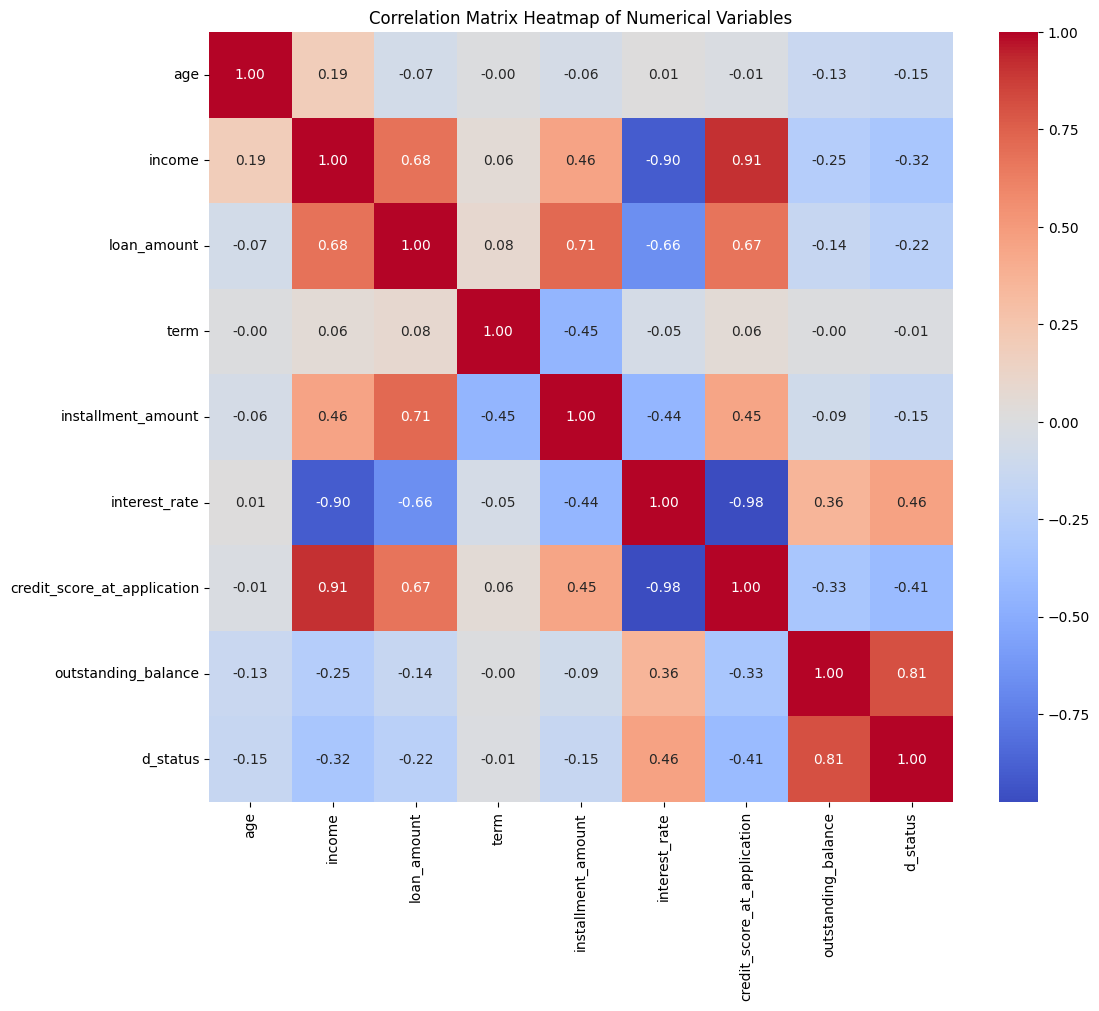

In [16]:
# Select only numerical columns for the correlation matrix
numerical_cols = df_train.select_dtypes(include=np.number).columns
df_numeric = df_train[numerical_cols]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap of Numerical Variables')
plt.show()

# FEATURE ENGINEERING

List of variables that could be addedo to the model:

1. Financial Ratios and Derived Features:   
  * Number of Active Loans
  * Installment-to-Income Ratio = Monthly Installment / Monthly Income

2. Employment & Income Stability Features:   
  * Employment Stability = Years at Current Job
  * Industry Stability Score
  * Has Side Income (Yes/No)

3. Customer Engagement Features:
  * Logins to Banking App
  * Auto-Pay Enrollment (Yes/No)
  * On-Time Payment Percentage
  * Number of Customer Service Calls or contacted

4. Geographic & Demographic Features
  * Region-Based Default Rate
  * Household Size

5. Loan Characteristics:
  * Loan Purpose Category (Categorical)
  * Interest Rate Spread = Loan Interest Rate - Market Average
  * interest rate fixed or dynamic

6. External Data Enrichment (if available):
  * Macroeconomic Indicators (Unemployment Rate, Inflation)



# SPLIT TRAIN-VALIDATION SET

In [17]:
# target variable
str_target_variable = "d_status"
# train and test set
X = df_train.copy()
y = df_train[str_target_variable]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_val.shape)

(6997, 12)
(3000, 12)


# ENCODE CATEGORICAL VARIABLES

In [18]:
# list of categorical variables
list_cat_features = df_train.select_dtypes(include=['object']).columns.tolist()
# print
print(len(list_cat_features))
print(list_cat_features)

# encode the categoroical variable with Target Encoding procedure
str_cat_feature = "gender"
df_encode = X_train.groupby(str_cat_feature, as_index=False).agg({"d_status":"sum"})
df_encode.columns = [str_cat_feature, str_cat_feature+"_encode"]
# merge the encoded variable with the main dataset
X_train = X_train.merge(df_encode, on = str_cat_feature, how="left")
X_val = X_val.merge(df_encode, on = str_cat_feature, how="left")

3
['account_no', 'gender', 'status']


# MODEL

## feature selection

In [49]:
list_features = [
    'age',
    'income',
    'loan_amount',
    'term',
    'installment_amount',
    'interest_rate',
    'credit_score_at_application',
    'gender_encode'

]

## XGradient Boosting

In [68]:
def objective(trial):

    # search space
    n_estimators = trial.suggest_int('n_estimators', low=50, high=200, step=50)
    n_learning_rate = trial.suggest_float('learning_rate', low=0.01, high=0.3, step=0.01)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse'])
    min_samples_split = trial.suggest_int('min_samples_split', low=2, high=4, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=1, high=5, step=1)
    max_depth = trial.suggest_int('max_depth', low=5, high=7, step=1)
    max_features = trial.suggest_categorical('max_features', [ 'sqrt','log2'])

    # random forest classifier
    gbc = GradientBoostingClassifier(n_estimators=n_estimators,
                                 criterion=criterion,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_depth=max_depth,
                                 max_features=max_features)

    # return score
    return cross_val_score(estimator=gbc,
                             X=X_train[list_features],
                             y=y_train,
                             scoring='f1_micro',
                             #n_jobs=-1
                           ).mean()

# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='maximize')

# perform hyperparamter tuning (while timing the process)
study.optimize(objective, n_trials=100)

# store the hyperpqrameters
param_best = study.best_params

print(f"---Bayesian Optimization---")
print(f"Number of iterations: {100}")
print(f"Best trial index: {study.best_trial.number}")
print(f"Best score: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_params}")

[I 2025-01-29 14:13:19,320] A new study created in memory with name: no-name-5a5c541d-0c8f-4292-8f25-a43cea10cfbe
[I 2025-01-29 14:13:34,953] Trial 0 finished with value: 0.9861368324313284 and parameters: {'n_estimators': 200, 'learning_rate': 0.14, 'criterion': 'squared_error', 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9861368324313284.
[I 2025-01-29 14:13:37,579] Trial 1 finished with value: 0.986994792198509 and parameters: {'n_estimators': 50, 'learning_rate': 0.29000000000000004, 'criterion': 'squared_error', 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.986994792198509.
[I 2025-01-29 14:13:49,958] Trial 2 finished with value: 0.986422853058307 and parameters: {'n_estimators': 200, 'learning_rate': 0.08, 'criterion': 'squared_error', 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 7, 'max_features': 'sqrt'}. Best is trial 

---Bayesian Optimization---
Number of iterations: 100
Best trial index: 91
Best score: 0.9888526498519351
Best hyperparameters: {'n_estimators': 50, 'learning_rate': 0.15000000000000002, 'criterion': 'squared_error', 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 5, 'max_features': 'sqrt'}


In [75]:

# Initialize and train the Gradient Boosting Regression model
gb_classifier = GradientBoostingClassifier(
    n_estimators = param_best["n_estimators"],
    learning_rate = param_best["learning_rate"],
    criterion = param_best["criterion"],
    min_samples_split = param_best["min_samples_split"],
    min_samples_leaf = param_best["min_samples_leaf"],
    max_depth = param_best["max_depth"],
    max_features = param_best["max_features"]
    )
gb_classifier.fit(X_train[list_features], y_train)

GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.15000000000000002, max_depth=5,
                           max_features='sqrt', min_samples_leaf=3,
                           min_samples_split=3, n_estimators=50)

In [76]:
# Make predictions on the test set
y_pred = gb_classifier.predict(X_val[list_features])

In [79]:
# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
# Calculate the confusion matrix
conf_matrix

Confusion Matrix:


array([[2779,   15],
       [  23,  183]])

In [81]:
# false positive rate, false negative rate
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]
# Calculate the false positive rate (FPR)
FPR = FP / (FP + TN)
# Calculate the false negative rate (FNR)
FNR = FN / (FN + TP)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)

# Calculate the recall
recall = recall_score(y_val, y_pred)

# Calculate the precision
precision = precision_score(y_val, y_pred)

# print
pd.DataFrame({"Metric":["Accuracy", "Recall", "Precision", "False Positive Rate", "False Negative Rate"],
              "Value":[accuracy, recall, precision, FPR, FNR]})

,Metric,Value
0,Accuracy,0.987333
1,Recall,0.888350
2,Precision,0.924242
3,False Positive Rate,0.005369
4,False Negative Rate,0.111650


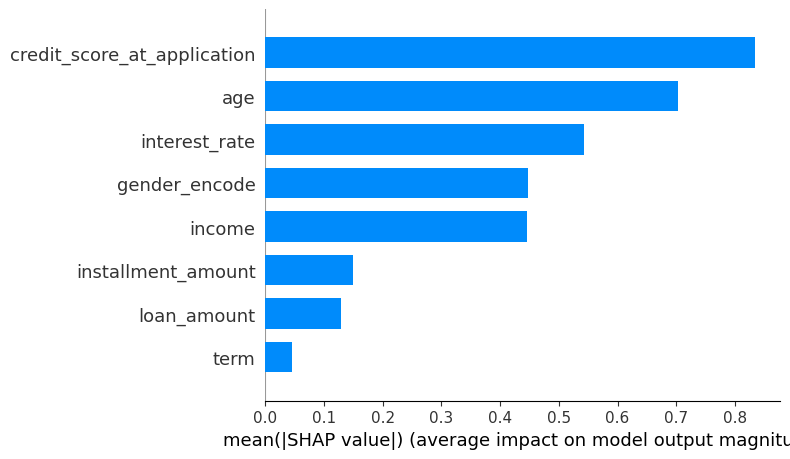

In [85]:
# Calculate SHAP values
explainer = shap.TreeExplainer(gb_classifier)
shap_values = explainer.shap_values(X_val[list_features])

# Summary plot
shap.summary_plot(shap_values, X_val[list_features],  plot_type="bar")

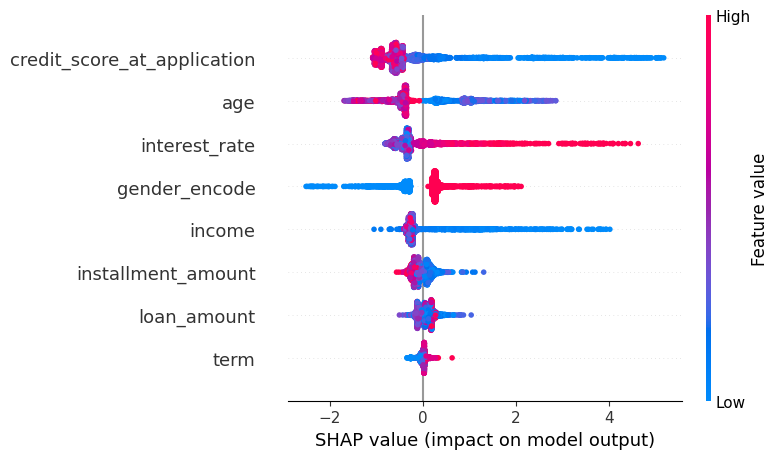

In [86]:
# Summary plot
shap.summary_plot(shap_values, X_val[list_features])

## Multivariate Distribution

In [58]:
# prompt: write a python code to fit a multivariate distribution with the variables: income, age, loan amount

from sklearn.mixture import GaussianMixture


# Initialize and fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42) # Adjust n_components as needed
gmm.fit(X_train[list_features])

# Now you can use gmm to predict probabilities or generate new samples
# Example: predict probabilities for each data point
probabilities = gmm.predict_proba(X_val[list_features])
predictions = gmm.predict(X_val[list_features])

In [54]:
y_val.value_counts()

,count
d_status,
0,2794
1,206
